In [1]:
#Drew inspiration from https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/04_Keras_Flowers_transfer_learning_solution.ipynb#scrollTo=LtAVr-4CP1rp
#Copy pasted some code snippets from the above link as well
import os, math, json
import numpy as np
import json
from matplotlib import pyplot as plt

import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/dtypes.py:519: FutureWarning: P

Tensorflow version 1.14.0


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
AUTO = tf.data.experimental.AUTOTUNE
# GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
# IMAGE_SIZE = [192,192]
# BATCH_SIZE = 64
# EPOCHS = 10
# VALIDATION_SPLIT = 0.2
# CLASSES = ['NORMAL', 'PNEUMONIA']
# #filenames = tf.gfile.Glob(GCS_PATTERN)
# split = int(len(filenames) * VALIDATION_SPLIT)
# training_filenames = filenames[split:]
# validation_filenames = filenames[:split]
# validation_steps = 30
# steps_per_epoch = 30
# print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
# validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
# steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
# print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

In [3]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])
  
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

In [4]:
# pretrained_model = keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
# pretrained_model.trainable = False
# from keras import models, layers


In [5]:
# model = tf.keras.Sequential([
#     pretrained_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss = 'sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [6]:
# training_dataset = get_batched_dataset(training_filenames)
# validation_dataset = get_batched_dataset(validation_filenames)

In [7]:
# print(training_dataset)
# # history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
# #                     validation_data=validation_dataset, validation_steps=validation_steps)

In [8]:
# print(history.history.keys())
# display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
# display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [9]:
# #print("Looking at these charts - it appears that we start overfitting after epoch 4.  This can also be seen in the reduced progress made on the main test set.")

# model = tf.keras.Sequential([
#     pretrained_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss = 'sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )
# history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=4,
#                     validation_data=validation_dataset, validation_steps=validation_steps)

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192,192]
BATCH_SIZE = 64
EPOCHS = 10
VALIDATION_SPLIT = 0.2
CLASSES = ['NORMAL', 'PNEUMONIA']
validation_steps = 30
steps_per_epoch = 30


In [11]:
healthy_filenames_test = tf.gfile.Glob('/home/keras/Documents/siraj/healthcare/chest_xray/test/NORMAL/*')
unhealthy_filenames_test = tf.gfile.Glob('/home/keras/Documents/siraj/healthcare/chest_xray/test/PNEUMONIA/*')
healthy_filenames_train = tf.gfile.Glob('/home/keras/Documents/siraj/healthcare/chest_xray/train/NORMAL/*')
unhealthy_filenames_train = tf.gfile.Glob('/home/keras/Documents/siraj/healthcare/chest_xray/train/PNEUMONIA/*')
print(len(healthy_filenames_test))


234


In [12]:
label_to_index = dict((name,index) for index,name in enumerate(CLASSES))

In [13]:
print(label_to_index)
train_data = healthy_filenames_train+unhealthy_filenames_train
test_data = healthy_filenames_test+unhealthy_filenames_test
all_image_labels_train = [0]*len(healthy_filenames_train)+[1]*len(unhealthy_filenames_train)
all_image_labels_test =[0]*len(healthy_filenames_test)+[1]*len(unhealthy_filenames_test)
print(int(len(train_data)+len(test_data)))
validation_steps =64
steps_per_epoch = 64
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

{'NORMAL': 0, 'PNEUMONIA': 1}
5840
With a batch size of 64, there will be 64 batches per training epoch and 64 batch(es) per validation run.


In [19]:
pretrained_model = keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False
from keras import models, layers
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 32769     
Total params: 21,835,553
Trainable params: 32,769
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  #print(image.shape())
  image = tf.image.resize(image, IMAGE_SIZE)
  #image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)


train_paths_ds = tf.data.Dataset.from_tensor_slices(train_data)
test_paths_ds = tf.data.Dataset.from_tensor_slices(test_data)

train_image_ds = train_paths_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_paths_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_train, tf.int64))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_test, tf.int64))
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))


In [21]:
# print(train_image_label_ds)
# print(test_image_label_ds)
# #print(all_image_labels_train)

In [22]:
#BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
train_ds = train_image_label_ds.shuffle(buffer_size=len(train_data))
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
train_ds = train_image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=len(train_data)))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
train_ds

test_ds = test_image_label_ds.shuffle(buffer_size=len(test_data))
test_ds = test_ds.repeat()
test_ds = test_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=len(test_data)))
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
test_ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [23]:
history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=10,
                    validation_data=test_ds, validation_steps=2)

Epoch 1/10
64/64 [==============================] - 86s 1s/step - loss: 0.5007 - acc: 0.8472 - val_loss: 5.3906 - val_acc: 0.6484
Epoch 2/10
64/64 [==============================] - 71s 1s/step - loss: 0.1543 - acc: 0.9424 - val_loss: 5.3906 - val_acc: 0.6484
Epoch 3/10
64/64 [==============================] - 71s 1s/step - loss: 0.1116 - acc: 0.9619 - val_loss: 5.3906 - val_acc: 0.6484
Epoch 4/10
64/64 [==============================] - 70s 1s/step - loss: 0.0821 - acc: 0.9700 - val_loss: 5.3906 - val_acc: 0.6484
Epoch 5/10
64/64 [==============================] - 70s 1s/step - loss: 0.0706 - acc: 0.9731 - val_loss: 5.3906 - val_acc: 0.6484
Epoch 6/10
64/64 [==============================] - 71s 1s/step - loss: 0.0613 - acc: 0.9761 - val_loss: 5.3906 - val_acc: 0.6484
Epoch 7/10
64/64 [==============================] - 71s 1s/step - loss: 0.0630 - acc: 0.9746 - val_loss: 5.3906 - val_acc: 0.6484
Epoch 8/10
64/64 [==============================] - 71s 1s/step - loss: 0.0487 - acc: 0.98

Appears best we can do is ~65% our test data.  This is better than the 50/50 of guessing, but not by a romantic amount.


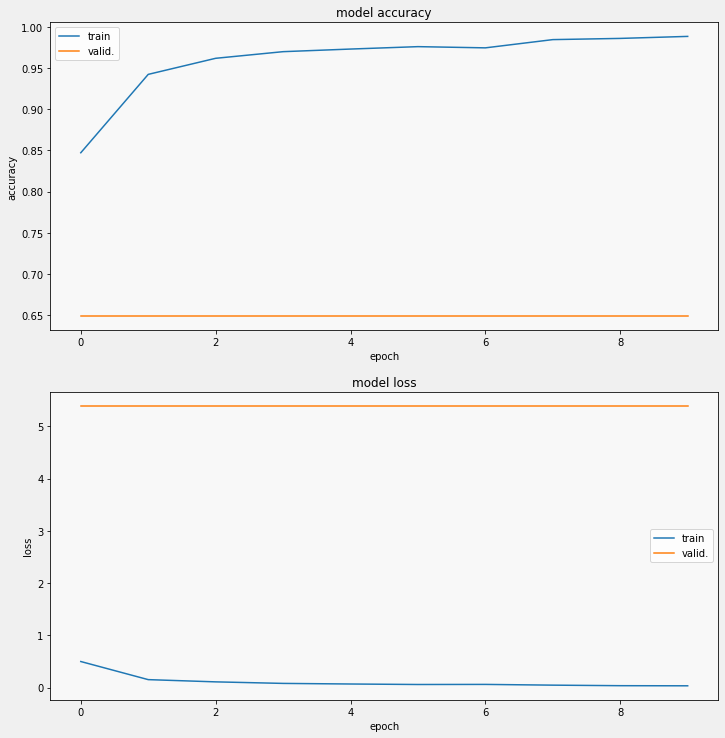

In [24]:
print("Appears best we can do is ~65% our test data.  This is better than the 50/50 of guessing, but not by a romantic amount.")
#print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
from IPython.display import Image
eggs =model.predict(train_ds, steps=1)

In [36]:
print("Image:",train_data[0])
print("Result:",eggs[0])
print("Status:",all_image_labels_train[0])
if (eggs[0] == all_image_labels_train[0]):
    print("Correct!")
else:
    print("Incorrect!")

Image: /home/keras/Documents/siraj/healthcare/chest_xray/train/NORMAL/NORMAL2-IM-1142-0001.jpeg
Result: [1.]
Status: 0
Incorrect!


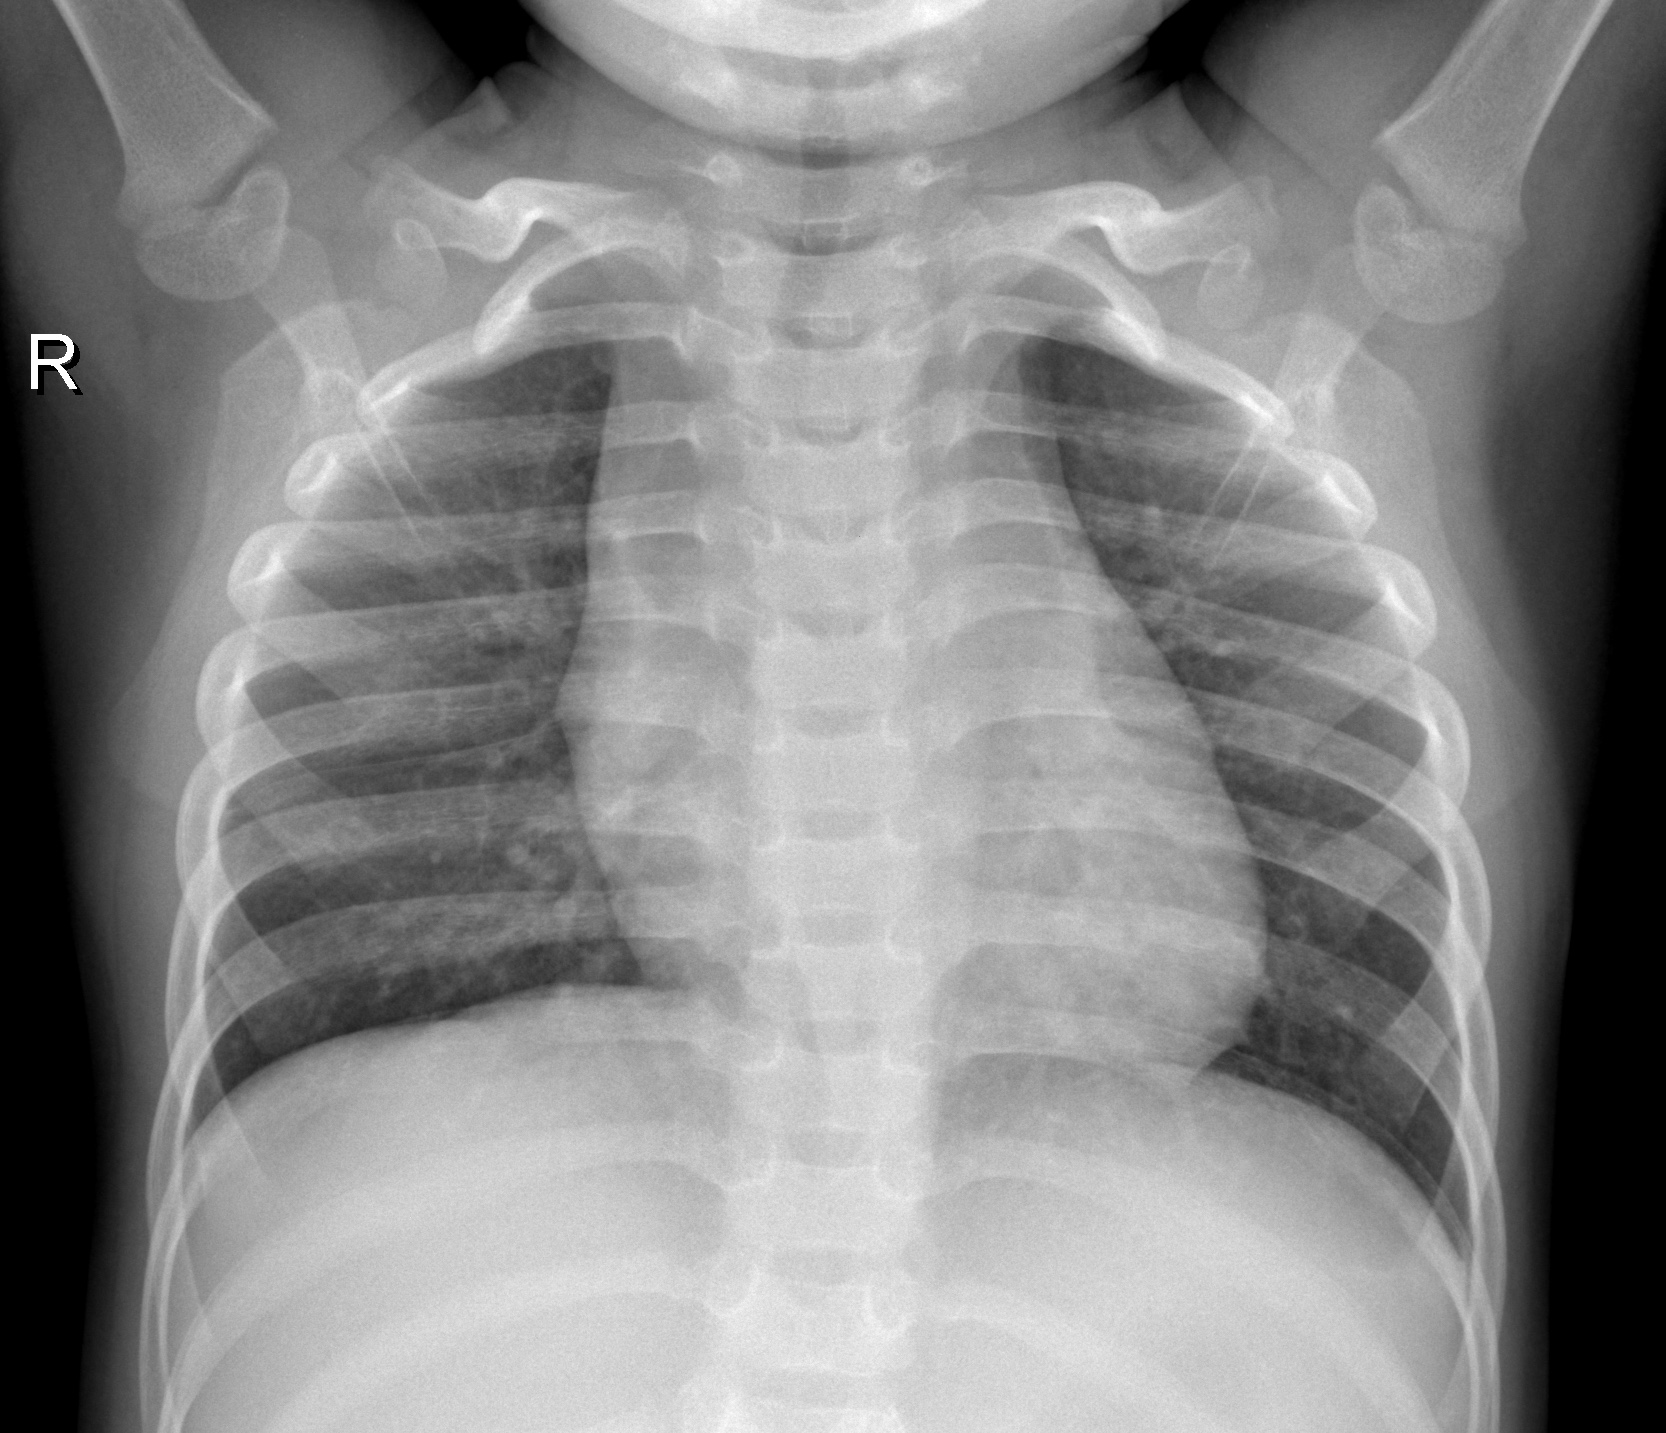

In [29]:
Image(filename=train_data[0]) 

In [35]:
print("Image:",train_data[1])
print("Result:",eggs[1])
print("Status:",all_image_labels_train[1])
if (eggs[1] == all_image_labels_train[1]):
    print("Correct!")
else:
    print("Incorrect!")

Image: /home/keras/Documents/siraj/healthcare/chest_xray/train/NORMAL/IM-0361-0001.jpeg
Result: [1.]
Status: 0
Incorrect!


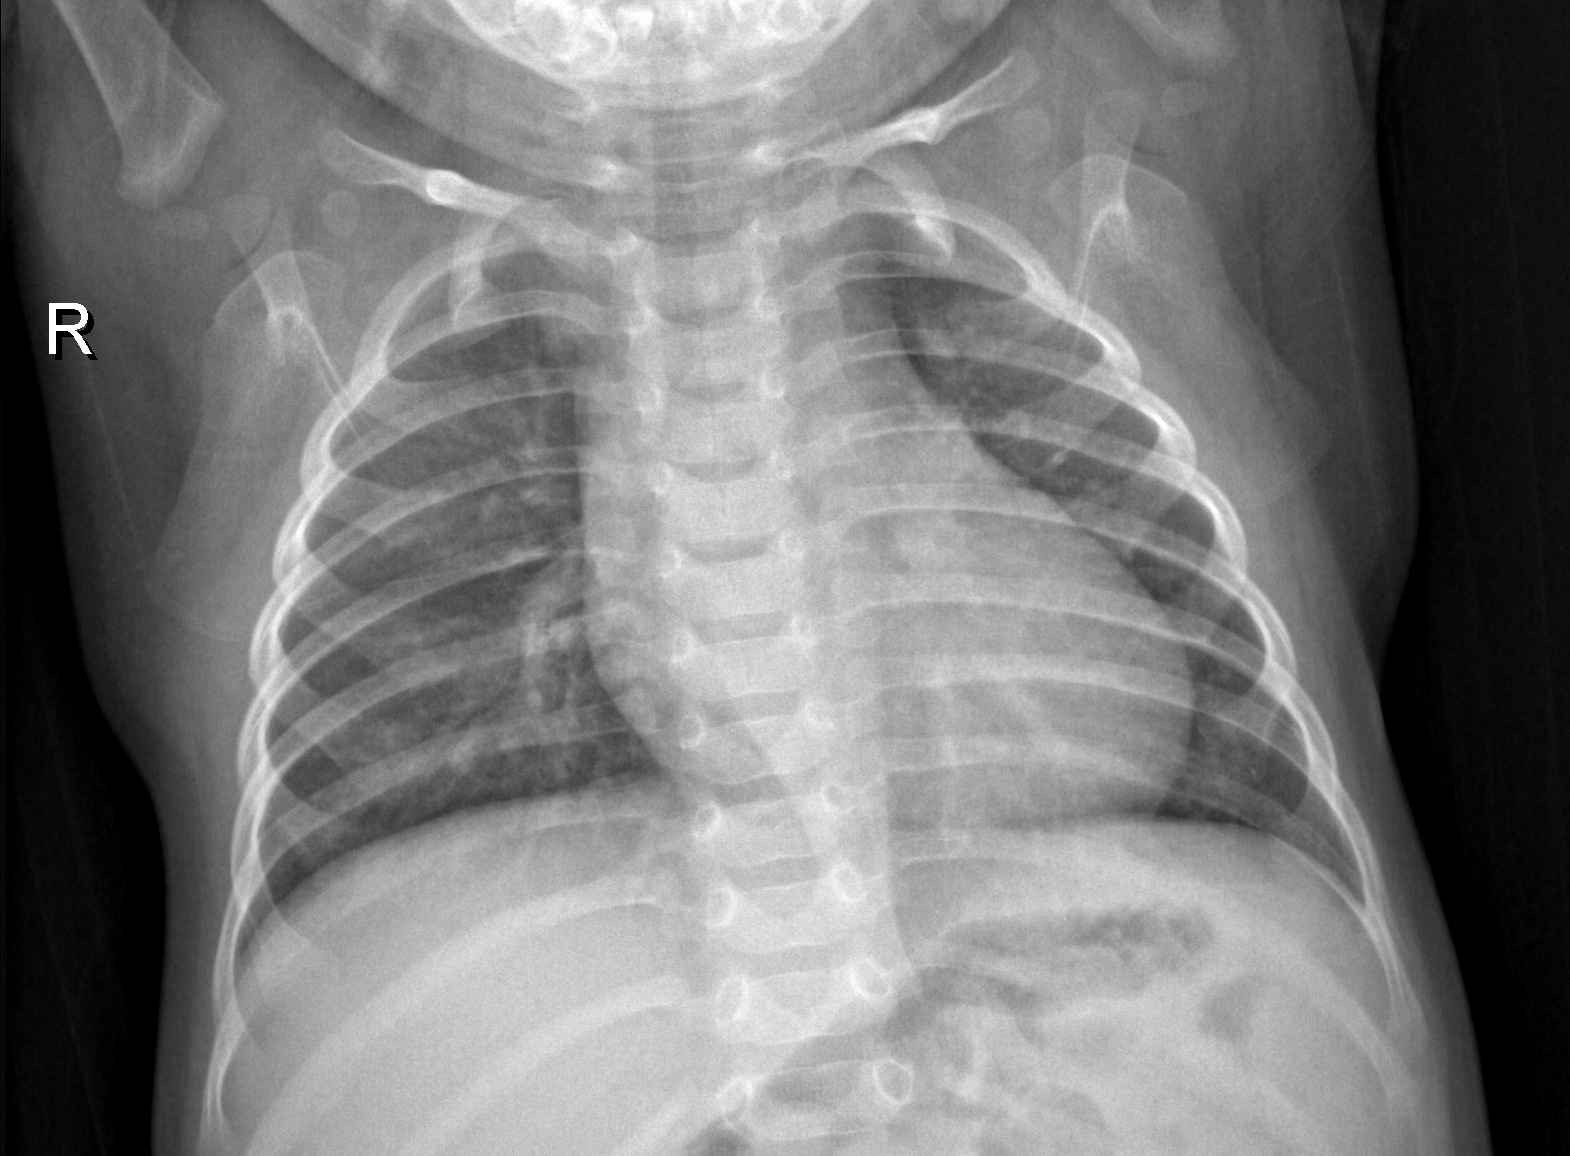

In [34]:
Image(filename=train_data[1]) 